<h1 align="center">Lab 3</h1>

<h2>Imports and Stuff</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

def displayImage(images, nrows = 1, ncols=1, title=[],image_max=0,plotsize=10):
    #Handle the case of 1 image
    if nrows == 1 and ncols == 1:
        images = [images]
    #Mismatch
    if len(images) != nrows*ncols:
        print("Number of images != number of subplots")
        return
    #Title mismathc
    if len(images) != len(title) and len(title)!=0:
        print("Number of images != number of titles")
        return
    fig = plt.figure(figsize=(plotsize,plotsize))
    ax = []
    for i in range(1, ncols*nrows +1):
        image = images[i-1]
        
        #Deal for various types
        type = image.dtype
        if np.issubdtype(type, np.integer):
            if image_max==0:
                im_max = np.iinfo(type).max
            else:
                im_max=copy.deepcopy(image_max)
        else:
            im_max = 1
        
        plt.gray()
        ax.append( fig.add_subplot(nrows, ncols,i))
        if len(title)!=0:
            ax[-1].set_title(title[i-1])
        plt.axis("off")
        plt.imshow(image,vmin=0,vmax=im_max)
    plt.show()
    
#Convert float to uint8
def im2int8(image):
    image = image.astype(np.float32)
    image = 255 * image
    image = image.astype(np.uint8)
    return image

#Converts an image to float32
def im2float32(image):
    type = image.dtype
    if np.issubdtype(type, np.integer):
        info = np.iinfo(image.dtype)
        image = image.astype(np.float32) / info.max
    return image

<h2>Lab Excercise</h2>

<b>Question 1: </b>Write a program that can create a mask of size N × N Gaussian filter.

In [2]:
#The 2D Gaussian Function
def gauss(x,y,sigma):
    return (1/(2*math.pi*(sigma**2)))*math.exp((-1*(x**2)-(y**2))/(2*(sigma**2)))

#Creates an NxN Gaussian filter for a given sigma
def gaussFilter(N,sigma):
    mask = np.zeros((N,N))
    adjustFactor = math.floor(N/2)
    for (x,y),value in np.ndenumerate(mask):
        mask[x,y] = gauss(x-adjustFactor,y-adjustFactor,sigma)
    return mask

print(gaussFilter(5,1))
print(gaussFilter(3,2))

[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]
[[0.0309875  0.03511344 0.0309875 ]
 [0.03511344 0.03978874 0.03511344]
 [0.0309875  0.03511344 0.0309875 ]]


<b>Question 2: </b>Write a spatial filtering function that takes in an image, I, an N × N filter as arguments, and obtain an output image
by performing spatial filtering operation on image I. Consider different ways, such as padding zeros or replication,
of handling the border pixels of the input image.

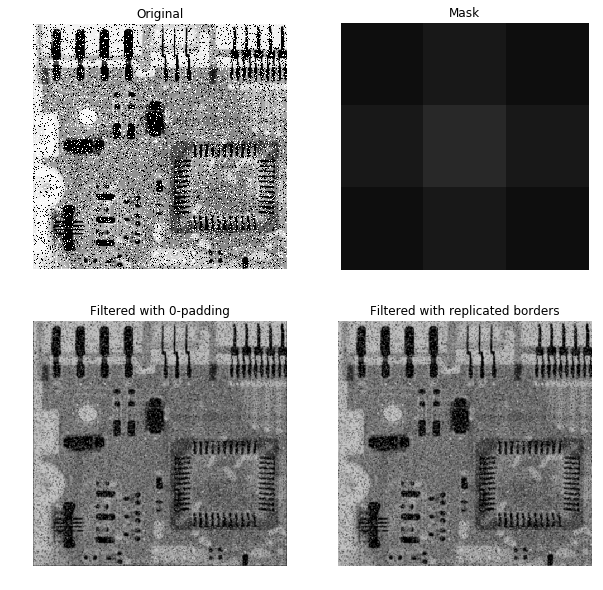

In [3]:
#TODO: These all work for 3x3 filters. For larger filters your 
#      mileage may vary

#Pads an array with zeros
def padWithZeros(array):
    rows = array.shape[0]
    cols = array.shape[1]
    padded = np.zeros((rows+2,cols+2))
    padded[1:rows+1,1:cols+1] = array
    return padded

#Removes padding from an array
def depad(array):
    return array[1:array.shape[0]-1,1:array.shape[1]-1]

#Replicate the ends of an array
def replicateBorders(array):
    rows = array.shape[0]
    cols = array.shape[1]
    padded = np.zeros((rows+2,cols+2))
    padded[1:rows+1,1:cols+1] = array
    for x in range(rows+2):
        padded[x,0] = padded[x,1]
        padded[x,cols+1] = padded[x,cols]
    for y in range(cols+2):
        padded[0,y] = padded[1,y]
        padded[rows+1,y] = padded[rows,y]
    return padded

#Performs spatial filtering with padding 0s
def spatialFilterPaddingZeros(image,mask):
    N = mask.shape[0]
    adjustFactor = math.floor(N/2)
    padded = padWithZeros(image)
    rows = padded.shape[0]
    cols = padded.shape[1]
    newImage = copy.deepcopy(padded)
    for (x,y),value in np.ndenumerate(padded):
        if x==0 or y==0 or x==rows-1 or y == cols-1:
            continue
        sum = 0
        for s in range(N):
            for t in range(N):
                sum += mask[s,t]*padded[x+s-adjustFactor,y+t-adjustFactor]
        newImage[x,y] = sum
    return newImage[1:rows-1,1:cols-1]

#Performs spatial filtering with replicating borders
def spatialFilterReplicatingBorders(image,mask):
    N = mask.shape[0]
    adjustFactor = math.floor(N/2)
    padded = replicateBorders(image)
    rows = padded.shape[0]
    cols = padded.shape[1]
    newImage = copy.deepcopy(padded)
    for (x,y),value in np.ndenumerate(padded):
        if x==0 or y==0 or x==rows-1 or y == cols-1:
            continue
        sum = 0
        for s in range(N):
            for t in range(N):
                sum += mask[s,t]*padded[x+s-adjustFactor,y+t-adjustFactor]
        newImage[x,y] = sum
    return newImage[1:rows-1,1:cols-1]

im = plt.imread("ckt_board.tif")
mask = gaussFilter(3,1)
newImPad = spatialFilterPaddingZeros(im,mask).astype(np.uint8)
newImRep = spatialFilterReplicatingBorders(im,mask).astype(np.uint8)

displayImage([im,mask,newImPad,newImRep],2,2,title=["Original","Mask","Filtered with 0-padding","Filtered with replicated borders"],image_max=255)

<b>Question 3: </b>Using the spatial filtering function in Item 2 to perform a Laplacian filtering on image ‘blurry_moon’. Save your
output image as ‘blurry_moon_laplacian.png’.

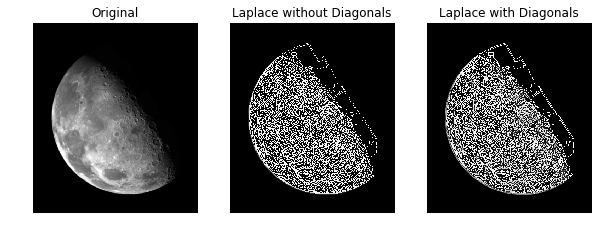

In [4]:
LaplaceMask1 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
LaplaceMask2 = np.array([[1,1,1],[1,-8,1],[1,1,1]])
blurryMoon = plt.imread("blurry_moon.tif")
blurryMoonLaplacian1 = spatialFilterReplicatingBorders(blurryMoon,LaplaceMask1).astype(np.uint8)
blurryMoonLaplacian2 = spatialFilterReplicatingBorders(blurryMoon,LaplaceMask2).astype(np.uint8)
displayImage([blurryMoon,blurryMoonLaplacian1,blurryMoonLaplacian2],1,3,title=["Original","Laplace without Diagonals","Laplace with Diagonals"])

<b>Question 4: </b>Apply spatial filtering on image ‘ckt_board’ using an box filter and a median filter, respectively. Save the output
images as ‘ckt_board_box.png’ and ‘ckt_board_median.png’, respectively.

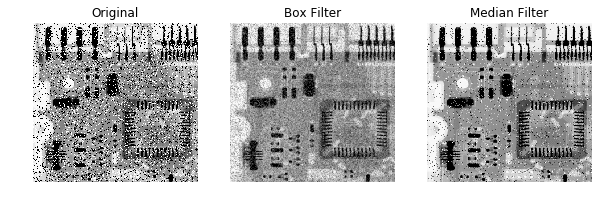

In [5]:
#Creates a box filter of NxN size
def boxFilter(N):
    scalar = 1.0/(N**2)
    mask = np.ones((N,N))
    return np.multiply(scalar,mask)

#Applies a median filter of size N to an image, padding with zeros
# TODO: Only works for 3x3 currently
def medianFilterPaddingZeros(image,N):
    adjustFactor = math.floor(N/2)
    padded = padWithZeros(image)
    rows = padded.shape[0]
    cols = padded.shape[1]
    newImage = copy.deepcopy(padded)
    for (x,y),value in np.ndenumerate(padded):
        if x==0 or y==0 or x==rows-1 or y == cols-1:
            continue
        window = padded[x-adjustFactor:x+adjustFactor,y-adjustFactor:y+adjustFactor]
        median = np.median(window)
        newImage[x,y] = median
    return newImage[1:rows-1,1:cols-1]

circuit = plt.imread("ckt_board.tif")
mask = boxFilter(3)
boxCircuit = spatialFilterPaddingZeros(circuit,mask).astype(np.uint8)
medianCircuit = medianFilterPaddingZeros(circuit,3).astype(np.uint8)
#saveToFile(medianCircuit,"ckt_board_median.png")

displayImage([circuit,boxCircuit,medianCircuit],1,3,title=["Original","Box Filter","Median Filter"])

<b>Question 5: </b>The image ‘skeleton’ shows a whole body bone scan, which is used to detect disease such as bone infection and
tumors. Using the image enhancement techniques we discussed so far in the class to enhance this image. The
objective is to sharpen the image and bring out more of the skeletal detail. For this purpose, consider approaches
to highlight fine detail, enhance prominent edges, and increase the dynamic range in the image.

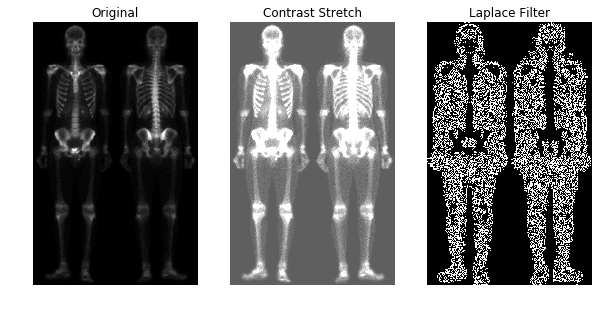

In [6]:
#Finds outliers in an image
def findOutliers(image):
    q1 = np.percentile(image,25)
    q3 = np.percentile(image,75)
    iqr = q3-q1
    
    for (x,y),value in np.ndenumerate(image):
        if value<q1-1.5*iqr:
            print("Pixel ",x,",",y," is a low outlier")
        elif value>q3+1.5*iqr:
            print("Pixel ",x,",",y," is a high outlier")
            
#The piecewise function used to perform the contrast stretch (float32 format)
def contrastStretchFunction(x,pl,ph):
    if x<pl:
        return 0
    elif x>ph:
        return 1
    else:
        return (x-pl)/(ph-pl)
            
#Performs a contrast stretch on a float32 image, taking into account the outliers
def contrastStretch(image):
    image = image.copy()
    q1 = np.percentile(image,25)
    q3 = np.percentile(image,75)
    iqr = q3-q1
    pl = q1-1.5*iqr
    ph = q3+1.5*iqr
    
    for (x,y),value in np.ndenumerate(image):
        image[x,y] = contrastStretchFunction(value,pl,ph)
    return image

skeleton = plt.imread("skeleton.tif")
#Apply a contrast stretch
skeleton2 = im2float32(skeleton)
skeleton2 = contrastStretch(skeleton2)
skeleton2 = im2int8(skeleton2)
#Apply a Laplace Filter
skeletonLaplace = spatialFilterPaddingZeros(skeleton2,LaplaceMask1)

displayImage([skeleton,skeleton2,skeletonLaplace],1,3,title=["Original","Contrast Stretch","Laplace Filter"])

<h2>Problems</h2>

<b>Question 1: </b>Consider the image in Table 1. Apply each of the given filters (a), (b), and comment on the results.

<img src="Table 1.png">

Filter A:
 [[0.    0.125 0.   ]
 [0.125 0.5   0.125]
 [0.    0.125 0.   ]]
Filter B:
 [[-0.125 -0.125 -0.125]
 [-0.125  1.    -0.125]
 [-0.125 -0.125 -0.125]]
Original:
 [[2 3 8 9 8]
 [1 2 1 7 9]
 [9 3 2 5 8]
 [7 9 1 1 7]
 [9 8 9 1 2]]
Filter A applied:
 [[1 3 5 7 6]
 [2 2 2 6 7]
 [5 4 2 4 6]
 [6 6 3 2 4]
 [6 7 5 2 2]]
Filter B applied:
 [[  1   1   5   4   4]
 [255 255 253   0   4]
 [  6 255 255   0   4]
 [  2   3 253 253   4]
 [  6   3   6 255   0]]


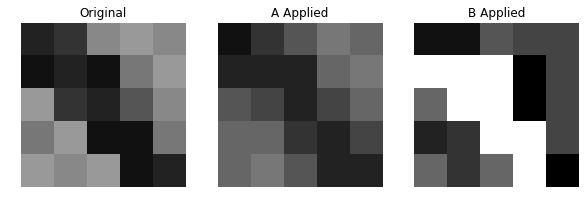

In [10]:
filterA = np.array([[0,1,0],[1,4,1],[0,1,0]])
filterA = np.multiply(1/8.0,filterA)
print("Filter A:\n",filterA)
filterB = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
filterB = np.multiply(1/8.0,filterB)
print("Filter B:\n",filterB)
table1 = np.array([[2,3,8,9,8],[1,2,1,7,9],[9,3,2,5,8],[7,9,1,1,7],[9,8,9,1,2]])
print("Original:\n",table1)
table1_again = copy.deepcopy(table1)
table1A = spatialFilterPaddingZeros(table1,filterA).astype(np.uint8)
print("Filter A applied:\n",table1A)
table1B = spatialFilterPaddingZeros(table1_again,filterB).astype(np.uint8)
print("Filter B applied:\n",table1B)
displayImage([table1,table1A,table1B],1,3,title=["Original","A Applied","B Applied"],image_max=15)

Filter A lowers the pixel values of the image on average, while Filter B increases the pixel values of the image on average

<b>Question 3:</b> In a given application, an averaging mask is applied to input images to reduce noise, and then a Laplacian mask is
applied to enhance the small details. Would the result be the same if the order of these operations were reversed?

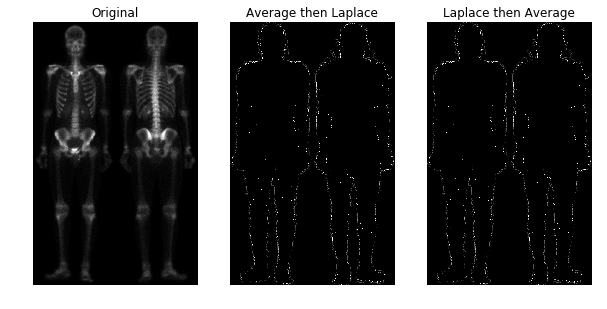

In [8]:
skeleton = plt.imread("skeleton.tif")
average = np.multiply(1/9.0,np.ones((3,3)))
LaplaceMask = np.array([[0,1,0],[1,-5,1],[0,1,0]])

skeleton1 = copy.deepcopy(skeleton)
skeleton2 = copy.deepcopy(skeleton)
#Average then Laplace
skeleton1 = spatialFilterPaddingZeros(skeleton1,average)
skeleton1 = spatialFilterPaddingZeros(skeleton1,LaplaceMask)
#Laplace then Average
skeleton2 = spatialFilterPaddingZeros(skeleton2,LaplaceMask)
skeleton2 = spatialFilterPaddingZeros(skeleton2,average)

displayImage([skeleton,skeleton1,skeleton2],1,3,title=["Original","Average then Laplace","Laplace then Average"])